In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
from typing import List, Tuple
import os

warnings.filterwarnings('ignore')

output_dir = 'outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(f"✓ Output directory ready: {output_dir}")

try:
    from smt.surrogate_models import KRG
    SMT_AVAILABLE = True
    print("✓ SMT Library loaded - Kriging active")
except ImportError:
    SMT_AVAILABLE = False
    print("⚠ SMT not found - Surrogate disabled")


✓ Output directory ready: outputs
✓ SMT Library loaded - Kriging active


In [2]:
class TenBarTruss:
    """
    10-Bar Truss Optimization Problem
    Based on project specifications with proper FEA calculations
    """
    
    def __init__(self):
        # Material properties
        self.rho = 0.1  # lb/in³
        self.E = 1e7    # Young's modulus (psi)
        
        # Bar lengths (inches) - from PDF
        self.L = np.array([360, 360, 360, 360, 510, 510, 510, 510, 510, 510])
        
        # ✅ CORRECT CONSTRAINTS (max allowable values)
        self.sigma_max = 25000.0  # psi (25 ksi) - maximum stress
        self.delta_max = 2.0      # inches - maximum displacement
        
        # Penalty coefficient
        self.P = 1e6
        
        # Design variables
        self.n_vars = 10
        
        # ✅ CORRECT BOUNDS (from PDF: 0.01 to 35.0)
        self.lb = np.full(10, 0.1)   # Practical lower bound
        self.ub = np.full(10, 35.0)
        
        # 10-bar truss geometry
        # Node coordinates (x, y) in inches
        self.nodes = np.array([
            [720, 360],  # Node 1
            [720, 0],    # Node 2
            [360, 360],  # Node 3
            [360, 0],    # Node 4
            [0, 360],    # Node 5
            [0, 0]       # Node 6
        ])
        
        # Element connectivity (0-indexed: bar i connects nodes[elements[i][0]] to nodes[elements[i][1]])
        self.elements = np.array([
            [2, 0],  # Bar 1: Node 3 -> Node 1
            [0, 3],  # Bar 2: Node 1 -> Node 4
            [3, 2],  # Bar 3: Node 4 -> Node 3
            [2, 1],  # Bar 4: Node 3 -> Node 2
            [0, 1],  # Bar 5: Node 1 -> Node 2
            [3, 1],  # Bar 6: Node 4 -> Node 2
            [4, 2],  # Bar 7: Node 5 -> Node 3
            [4, 3],  # Bar 8: Node 5 -> Node 4
            [5, 2],  # Bar 9: Node 6 -> Node 3
            [5, 3],  # Bar 10: Node 6 -> Node 4
        ])
        
        # Applied loads (100 kips = 100,000 lbs downward at nodes 2 and 4)
        self.n_dof = 2 * len(self.nodes)  # 2 DOFs per node (x, y)
        self.forces = np.zeros(self.n_dof)
        self.forces[2 * 1 + 1] = -100000  # Node 2, Y-direction (index 3)
        self.forces[2 * 3 + 1] = -100000  # Node 4, Y-direction (index 7)
        
        # Fixed DOFs (supports at nodes 5 and 6)
        self.fixed_dofs = [2*4, 2*4+1, 2*5, 2*5+1]  # Nodes 5 and 6 fully fixed
        
    def calculate_weight(self, X: np.ndarray) -> float:
        """Calculate total weight: W = ρ × Σ(A_i × L_i)"""
        return self.rho * np.sum(X * self.L)
    
    def analyze_truss(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform structural analysis using Direct Stiffness Method
        Returns: (stresses, displacements)
        """
        n_dof = self.n_dof
        K_global = np.zeros((n_dof, n_dof))
        
        # Assemble global stiffness matrix
        for i, (n1, n2) in enumerate(self.elements):
            # Element geometry
            x1, y1 = self.nodes[n1]
            x2, y2 = self.nodes[n2]
            L_elem = self.L[i]
            
            # Direction cosines
            cos_theta = (x2 - x1) / L_elem
            sin_theta = (y2 - y1) / L_elem
            
            # Element stiffness matrix in global coordinates
            A_i = X[i]
            k = (self.E * A_i) / L_elem
            
            c2 = cos_theta**2
            s2 = sin_theta**2
            cs = cos_theta * sin_theta
            
            K_elem = k * np.array([
                [ c2,  cs, -c2, -cs],
                [ cs,  s2, -cs, -s2],
                [-c2, -cs,  c2,  cs],
                [-cs, -s2,  cs,  s2]
            ])
            
            # Global DOF indices
            dofs = [2*n1, 2*n1+1, 2*n2, 2*n2+1]
            
            # Add to global stiffness matrix
            for ii in range(4):
                for jj in range(4):
                    K_global[dofs[ii], dofs[jj]] += K_elem[ii, jj]
        
        # Apply boundary conditions (eliminate fixed DOFs)
        free_dofs = [i for i in range(n_dof) if i not in self.fixed_dofs]
        K_reduced = K_global[np.ix_(free_dofs, free_dofs)]
        F_reduced = self.forces[free_dofs]
        
        # Solve for displacements
        try:
            U_reduced = np.linalg.solve(K_reduced, F_reduced)
        except np.linalg.LinAlgError:
            # Singular matrix - return large penalties
            return np.full(10, 1e6), np.full(len(self.nodes), 1e6)
        
        # Full displacement vector
        U_full = np.zeros(n_dof)
        U_full[free_dofs] = U_reduced
        
        # Calculate member forces and stresses
        stresses = np.zeros(10)
        for i, (n1, n2) in enumerate(self.elements):
            x1, y1 = self.nodes[n1]
            x2, y2 = self.nodes[n2]
            L_elem = self.L[i]
            
            cos_theta = (x2 - x1) / L_elem
            sin_theta = (y2 - y1) / L_elem
            
            # Displacement in local coordinates
            u1x, u1y = U_full[2*n1], U_full[2*n1+1]
            u2x, u2y = U_full[2*n2], U_full[2*n2+1]
            
            # Axial deformation
            delta_L = (u2x - u1x) * cos_theta + (u2y - u1y) * sin_theta
            
            # Stress = E × strain
            strain = delta_L / L_elem
            stresses[i] = abs(self.E * strain)
        
        # Nodal displacements (magnitude)
        node_displacements = np.zeros(len(self.nodes))
        for j in range(len(self.nodes)):
            ux = U_full[2*j]
            uy = U_full[2*j+1]
            node_displacements[j] = np.sqrt(ux**2 + uy**2)
        
        return stresses, node_displacements
    
    def evaluate_constraints(self, X: np.ndarray) -> Tuple[float, float]:
        """
        Evaluate constraint violations
        penalty = P × Σ(max(0, σᵢ - σ_max)) + P × Σ(max(0, δⱼ - δ_max))
        """
        stresses, displacements = self.analyze_truss(X)
        
        # Stress violations
        stress_violations = np.maximum(0, stresses - self.sigma_max)
        C_stress = np.sum(stress_violations)
        
        # Displacement violations
        disp_violations = np.maximum(0, displacements - self.delta_max)
        C_disp = np.sum(disp_violations)
        
        return C_stress, C_disp
    
    def fitness(self, X: np.ndarray) -> float:
        """
        Fitness function: F = W(X) + P × (C_stress + C_disp)
        
        Where:
        - W(X) = total weight
        - C_stress = sum of stress violations
        - C_disp = sum of displacement violations
        """
        X = np.clip(X, self.lb, self.ub)
        
        # Weight calculation
        W = self.calculate_weight(X)
        
        # Constraint violations
        C_stress, C_disp = self.evaluate_constraints(X)
        
        # Total fitness
        fitness_value = W + self.P * (C_stress + C_disp)
        
        return fitness_value
    
    def get_bounds(self):
        """Return design variable bounds"""
        return self.lb, self.ub


In [3]:
class SurrogateManager:
    """Manages surrogate model training and predictions"""
    
    def __init__(self, n_vars=10, max_history=200):
        self.model = None
        self.n_vars = n_vars
        self.X_train = []
        self.y_train = []
        self.max_history = max_history
        self.is_trained = False
        self.min_samples = max(30, 3 * n_vars)
        
        if SMT_AVAILABLE:
            self.model = KRG(theta0=[1e-2]*n_vars, print_global=False)
    
    def add_sample(self, X, y):
        """Add a sample to training data"""
        self.X_train.append(X.copy())
        self.y_train.append(y)
    
    def update_model(self):
        """Train/update surrogate model with recent data"""
        if len(self.X_train) < self.min_samples or not SMT_AVAILABLE:
            return
        
        # Use recent samples
        X = np.array(self.X_train[-self.max_history:])
        y_raw = np.array(self.y_train[-self.max_history:])
        
        # Filter out infeasible solutions (very high penalty)
        valid_mask = y_raw < 1e8
        if np.sum(valid_mask) < self.min_samples:
            return
        
        X = X[valid_mask]
        y_raw = y_raw[valid_mask]
        
        # Normalize targets
        self.y_min = np.min(y_raw)
        self.y_max = np.max(y_raw)
        
        if (self.y_max - self.y_min) < 1e-6:
            return
        
        y_normalized = (y_raw - self.y_min) / (self.y_max - self.y_min)
        y = y_normalized.reshape(-1, 1)
        
        try:
            self.model.set_training_values(X, y)
            self.model.train()
            self.is_trained = True
        except Exception as e:
            self.is_trained = False
    
    def predict(self, X):
        """Predict fitness value using surrogate"""
        if not self.is_trained:
            return None
        
        try:
            y_norm = self.model.predict_values(X.reshape(1, -1))[0, 0]
            y_norm = np.clip(y_norm, -0.2, 1.2)
            return y_norm * (self.y_max - self.y_min) + self.y_min
        except:
            return None


In [4]:
class GeneticAlgorithm:
    """Genetic Algorithm implementation"""
    
    def __init__(self, fitness_func, n_vars, lb, ub, surrogate_manager=None, 
                 pop_size=50, surrogate_ratio=0.3):
        self.fitness_func = fitness_func
        self.n_vars = n_vars
        self.lb = lb
        self.ub = ub
        self.sm = surrogate_manager
        self.pop_size = pop_size
        self.surrogate_ratio = surrogate_ratio
        self.crossover_prob = 0.3
        self.mutation_prob = 0.1
        self.tournament_size = 5
        self.elite_count = 2
    
    def tournament_selection(self, pop, fitness_vals):
        """Tournament selection with size 5"""
        indices = np.random.choice(len(pop), self.tournament_size, replace=False)
        tournament_fitness = fitness_vals[indices]
        winner_idx = indices[np.argmin(tournament_fitness)]
        return pop[winner_idx].copy()
    
    def run(self, max_iterations):
        """Run GA optimization"""
        
        # Initialize population
        pop = np.random.uniform(self.lb, self.ub, (self.pop_size, self.n_vars))
        fitness_vals = np.array([self.fitness_func(ind) for ind in pop])
        
        # Add initial samples to surrogate
        if self.sm:
            for i in range(len(pop)):
                self.sm.add_sample(pop[i], fitness_vals[i])
            self.sm.update_model()
        
        best_hist = []
        start_time = time.time()
        
        for it in range(max_iterations):
            # Elitism: Keep best individuals
            sorted_idx = np.argsort(fitness_vals)
            new_pop = [pop[i].copy() for i in sorted_idx[:self.elite_count]]
            new_fitness = [fitness_vals[i] for i in sorted_idx[:self.elite_count]]
            
            # Generate offspring
            while len(new_pop) < self.pop_size:
                # Selection
                p1 = self.tournament_selection(pop, fitness_vals)
                p2 = self.tournament_selection(pop, fitness_vals)
                
                # Crossover (one-point)
                c1, c2 = p1.copy(), p2.copy()
                if np.random.random() < self.crossover_prob:
                    pt = np.random.randint(1, self.n_vars)
                    c1 = np.concatenate([p1[:pt], p2[pt:]])
                    c2 = np.concatenate([p2[:pt], p1[pt:]])
                
                # Mutation (uniform)
                for child in [c1, c2]:
                    if len(new_pop) >= self.pop_size:
                        break
                    
                    for gene_idx in range(self.n_vars):
                        if np.random.random() < self.mutation_prob:
                            child[gene_idx] = np.random.uniform(
                                self.lb[gene_idx], self.ub[gene_idx]
                            )
                    
                    child = np.clip(child, self.lb, self.ub)
                    new_pop.append(child)
            
            pop = np.array(new_pop)
            
            # Evaluate new individuals (with surrogate assistance)
            temp_fitness = []
            for i in range(self.elite_count, self.pop_size):
                ind = pop[i]
                
                # Use surrogate probabilistically
                use_surrogate = (self.sm and self.sm.is_trained and 
                               it > 100 and
                               np.random.random() < self.surrogate_ratio)
                
                if use_surrogate:
                    pred = self.sm.predict(ind)
                    if pred is not None:
                        # Verify occasionally
                        if np.random.random() < 0.2:
                            true_val = self.fitness_func(ind)
                            self.sm.add_sample(ind, true_val)
                            temp_fitness.append(true_val)
                        else:
                            temp_fitness.append(pred)
                    else:
                        val = self.fitness_func(ind)
                        self.sm.add_sample(ind, val)
                        temp_fitness.append(val)
                else:
                    val = self.fitness_func(ind)
                    if self.sm:
                        self.sm.add_sample(ind, val)
                    temp_fitness.append(val)
            
            fitness_vals = np.array(new_fitness + temp_fitness)
            
            # Update surrogate model periodically
            if self.sm and it % 50 == 0:
                self.sm.update_model()
            
            best_hist.append(np.min(fitness_vals))
        
        exec_time = time.time() - start_time
        best_idx = np.argmin(fitness_vals)
        
        # Always return TRUE fitness
        final_fitness = self.fitness_func(pop[best_idx])
        
        return final_fitness, exec_time, best_hist, pop[best_idx]


In [5]:
class DifferentialEvolution:
    """Differential Evolution implementation"""
    
    def __init__(self, fitness_func, n_vars, lb, ub, surrogate_manager=None, 
                 pop_size=50, F=0.8, CR=0.9, surrogate_ratio=0.3):
        self.fitness_func = fitness_func
        self.n_vars = n_vars
        self.lb = lb
        self.ub = ub
        self.sm = surrogate_manager
        self.pop_size = pop_size
        self.F = F
        self.CR = CR
        self.surrogate_ratio = surrogate_ratio
    
    def run(self, max_iterations):
        """Run DE optimization"""
        
        pop = np.random.uniform(self.lb, self.ub, (self.pop_size, self.n_vars))
        fitness = np.array([self.fitness_func(ind) for ind in pop])
        
        if self.sm:
            for i in range(len(pop)):
                self.sm.add_sample(pop[i], fitness[i])
            self.sm.update_model()
        
        best_hist = []
        start_time = time.time()
        
        for it in range(max_iterations):
            new_pop = []
            new_fitness = []
            
            use_surrogate_prob = 0.0 if it < 100 else self.surrogate_ratio
            
            for i in range(self.pop_size):
                indices = [idx for idx in range(self.pop_size) if idx != i]
                a, b, c = pop[np.random.choice(indices, 3, replace=False)]
                
                mutant = a + self.F * (b - c)
                mutant = np.clip(mutant, self.lb, self.ub)
                
                trial = np.copy(pop[i])
                cross_points = np.random.rand(self.n_vars) < self.CR
                if not np.any(cross_points):
                    cross_points[np.random.randint(0, self.n_vars)] = True
                trial[cross_points] = mutant[cross_points]
                
                use_surrogate = (self.sm and self.sm.is_trained and 
                               np.random.random() < use_surrogate_prob)
                
                if use_surrogate:
                    val = self.sm.predict(trial)
                    if val is None or np.random.random() < 0.25:
                        val = self.fitness_func(trial)
                        if self.sm:
                            self.sm.add_sample(trial, val)
                else:
                    val = self.fitness_func(trial)
                    if self.sm:
                        self.sm.add_sample(trial, val)
                
                if val < fitness[i]:
                    new_pop.append(trial)
                    new_fitness.append(val)
                else:
                    new_pop.append(pop[i])
                    new_fitness.append(fitness[i])
            
            pop = np.array(new_pop)
            fitness = np.array(new_fitness)
            
            if self.sm and it % 50 == 0:
                self.sm.update_model()
            
            best_hist.append(np.min(fitness))
        
        exec_time = time.time() - start_time
        best_idx = np.argmin(fitness)
        final_fitness = self.fitness_func(pop[best_idx])
        
        return final_fitness, exec_time, best_hist, pop[best_idx]


In [6]:
class ParticleSwarmOptimization:
    """Particle Swarm Optimization implementation"""
    
    def __init__(self, fitness_func, n_vars, lb, ub, surrogate_manager=None,
                 swarm_size=50, surrogate_ratio=0.3):
        self.fitness_func = fitness_func
        self.n_vars = n_vars
        self.lb = lb
        self.ub = ub
        self.sm = surrogate_manager
        self.swarm_size = swarm_size
        self.surrogate_ratio = surrogate_ratio
        self.c1 = 2.0
        self.c2 = 2.0
        self.w_max = 0.9
        self.w_min = 0.4
    
    def run(self, max_iterations):
        """Run PSO optimization"""
        
        # Initialize swarm
        X = np.random.uniform(self.lb, self.ub, (self.swarm_size, self.n_vars))
        V = np.random.uniform(-0.1, 0.1, (self.swarm_size, self.n_vars))
        
        fitness = np.array([self.fitness_func(x) for x in X])
        
        if self.sm:
            for i in range(len(X)):
                self.sm.add_sample(X[i], fitness[i])
            self.sm.update_model()
        
        # Personal and global bests
        pbest_X = X.copy()
        pbest_fit = fitness.copy()
        gbest_idx = np.argmin(fitness)
        gbest_X = X[gbest_idx].copy()
        gbest_fit = fitness[gbest_idx]
        
        best_hist = []
        start_time = time.time()
        
        for it in range(max_iterations):
            # Adaptive inertia weight
            w = self.w_max - (self.w_max - self.w_min) * it / max_iterations
            
            # Update velocity and position
            r1 = np.random.rand(self.swarm_size, self.n_vars)
            r2 = np.random.rand(self.swarm_size, self.n_vars)
            
            V = (w * V + 
                 self.c1 * r1 * (pbest_X - X) + 
                 self.c2 * r2 * (gbest_X - X))
            
            X = X + V
            X = np.clip(X, self.lb, self.ub)
            
            # Evaluate particles
            current_fitness = []
            for i in range(self.swarm_size):
                use_surrogate = (self.sm and self.sm.is_trained and 
                               it > 100 and
                               np.random.random() < self.surrogate_ratio)
                
                if use_surrogate:
                    pred = self.sm.predict(X[i])
                    if pred is not None and np.random.random() > 0.2:
                        current_fitness.append(pred)
                    else:
                        val = self.fitness_func(X[i])
                        self.sm.add_sample(X[i], val)
                        current_fitness.append(val)
                else:
                    val = self.fitness_func(X[i])
                    if self.sm:
                        self.sm.add_sample(X[i], val)
                    current_fitness.append(val)
            
            current_fitness = np.array(current_fitness)
            
            # Update personal bests
            improved = current_fitness < pbest_fit
            pbest_X[improved] = X[improved]
            pbest_fit[improved] = current_fitness[improved]
            
            # Update global best
            min_idx = np.argmin(pbest_fit)
            if pbest_fit[min_idx] < gbest_fit:
                gbest_fit = pbest_fit[min_idx]
                gbest_X = pbest_X[min_idx].copy()
            
            # Update surrogate
            if self.sm and it % 50 == 0:
                self.sm.update_model()
            
            best_hist.append(gbest_fit)
        
        exec_time = time.time() - start_time
        final_fitness = self.fitness_func(gbest_X)
        
        return final_fitness, exec_time, best_hist, gbest_X


In [7]:
class ArtificialBeeColony:
    """Artificial Bee Colony implementation"""
    
    def __init__(self, fitness_func, n_vars, lb, ub, surrogate_manager=None, 
                 colony_size=50, limit=20, surrogate_ratio=0.3):
        self.fitness_func = fitness_func
        self.n_vars = n_vars
        self.lb = lb
        self.ub = ub
        self.sm = surrogate_manager
        self.colony_size = colony_size
        self.limit = limit
        self.surrogate_ratio = surrogate_ratio
    
    def run(self, max_iterations):
        """Run ABC optimization"""
        
        n_employed = self.colony_size // 2
        
        food_sources = np.random.uniform(self.lb, self.ub, (n_employed, self.n_vars))
        fitness = np.array([self.fitness_func(x) for x in food_sources])
        trial_counter = np.zeros(n_employed)
        
        if self.sm:
            for i in range(n_employed):
                self.sm.add_sample(food_sources[i], fitness[i])
            self.sm.update_model()
        
        best_hist = []
        start_time = time.time()
        
        for it in range(max_iterations):
            use_surrogate_prob = 0.0 if it < 100 else self.surrogate_ratio
            
            # EMPLOYED BEE PHASE
            for i in range(n_employed):
                k = np.random.choice([j for j in range(n_employed) if j != i])
                phi = np.random.uniform(-1, 1, self.n_vars)
                candidate = food_sources[i] + phi * (food_sources[i] - food_sources[k])
                candidate = np.clip(candidate, self.lb, self.ub)
                
                use_surrogate = (self.sm and self.sm.is_trained and 
                               np.random.random() < use_surrogate_prob)
                
                if use_surrogate:
                    candidate_fitness = self.sm.predict(candidate)
                    if candidate_fitness is None or np.random.random() < 0.2:
                        candidate_fitness = self.fitness_func(candidate)
                        if self.sm:
                            self.sm.add_sample(candidate, candidate_fitness)
                else:
                    candidate_fitness = self.fitness_func(candidate)
                    if self.sm:
                        self.sm.add_sample(candidate, candidate_fitness)
                
                if candidate_fitness < fitness[i]:
                    food_sources[i] = candidate
                    fitness[i] = candidate_fitness
                    trial_counter[i] = 0
                else:
                    trial_counter[i] += 1
            
            # ONLOOKER BEE PHASE
            fitness_sum = np.sum(1.0 / (fitness + 1e-10))
            probabilities = (1.0 / (fitness + 1e-10)) / fitness_sum
            
            for _ in range(n_employed):
                i = np.random.choice(n_employed, p=probabilities)
                
                k = np.random.choice([j for j in range(n_employed) if j != i])
                phi = np.random.uniform(-1, 1, self.n_vars)
                candidate = food_sources[i] + phi * (food_sources[i] - food_sources[k])
                candidate = np.clip(candidate, self.lb, self.ub)
                
                use_surrogate = (self.sm and self.sm.is_trained and 
                               np.random.random() < use_surrogate_prob)
                
                if use_surrogate:
                    candidate_fitness = self.sm.predict(candidate)
                    if candidate_fitness is None or np.random.random() < 0.2:
                        candidate_fitness = self.fitness_func(candidate)
                        if self.sm:
                            self.sm.add_sample(candidate, candidate_fitness)
                else:
                    candidate_fitness = self.fitness_func(candidate)
                    if self.sm:
                        self.sm.add_sample(candidate, candidate_fitness)
                
                if candidate_fitness < fitness[i]:
                    food_sources[i] = candidate
                    fitness[i] = candidate_fitness
                    trial_counter[i] = 0
            
            # SCOUT BEE PHASE
            for i in range(n_employed):
                if trial_counter[i] > self.limit:
                    food_sources[i] = np.random.uniform(self.lb, self.ub, self.n_vars)
                    fitness[i] = self.fitness_func(food_sources[i])
                    trial_counter[i] = 0
                    if self.sm:
                        self.sm.add_sample(food_sources[i], fitness[i])
            
            if self.sm and it % 50 == 0:
                self.sm.update_model()
            
            best_hist.append(np.min(fitness))
        
        exec_time = time.time() - start_time
        best_idx = np.argmin(fitness)
        final_fitness = self.fitness_func(food_sources[best_idx])
        
        return final_fitness, exec_time, best_hist, food_sources[best_idx]


In [8]:
class FireflyAlgorithm:
    """Firefly Algorithm implementation"""
    
    def __init__(self, fitness_func, n_vars, lb, ub, surrogate_manager=None,
                 pop_size=50, alpha=0.5, beta0=1.0, gamma=1.0, surrogate_ratio=0.3):
        self.fitness_func = fitness_func
        self.n_vars = n_vars
        self.lb = lb
        self.ub = ub
        self.sm = surrogate_manager
        self.pop_size = pop_size
        self.alpha = alpha
        self.beta0 = beta0
        self.gamma = gamma
        self.surrogate_ratio = surrogate_ratio
    def run(self, max_iterations):
        
        pop = np.random.uniform(self.lb, self.ub, (self.pop_size, self.n_vars))
        fitness = np.array([self.fitness_func(x) for x in pop])
        light_intensity = 1.0 / (fitness + 1e-10)
    
        if self.sm:
            for i in range(len(pop)):
                self.sm.add_sample(pop[i], fitness[i])
            self.sm.update_model()
        
        best_hist = []
        start_time = time.time()
        
        for it in range(max_iterations):
            alpha_t = self.alpha * (0.95 ** it)
            use_surrogate_prob = 0.0 if it < 100 else self.surrogate_ratio
            
            for i in range(self.pop_size):
                for j in range(self.pop_size):
                    if light_intensity[j] > light_intensity[i]:
                        r = np.linalg.norm(pop[i] - pop[j])
                        beta = self.beta0 * np.exp(-self.gamma * r**2)
                        random_vec = np.random.uniform(-0.5, 0.5, self.n_vars)
                        pop[i] = pop[i] + beta * (pop[j] - pop[i]) + alpha_t * random_vec
                        pop[i] = np.clip(pop[i], self.lb, self.ub)
                        
                        use_surrogate = (self.sm and self.sm.is_trained and 
                                       np.random.random() < use_surrogate_prob)
                        
                        if use_surrogate:
                            new_fitness = self.sm.predict(pop[i])
                            if new_fitness is None or np.random.random() < 0.2:
                                new_fitness = self.fitness_func(pop[i])
                                if self.sm:
                                    self.sm.add_sample(pop[i], new_fitness)
                        else:
                            new_fitness = self.fitness_func(pop[i])
                            if self.sm:
                                self.sm.add_sample(pop[i], new_fitness)
                        
                        if new_fitness < fitness[i]:
                            fitness[i] = new_fitness
                            light_intensity[i] = 1.0 / (fitness[i] + 1e-10)
            
            if self.sm and it % 50 == 0:
                self.sm.update_model()
            
            best_hist.append(np.min(fitness))
        
        exec_time = time.time() - start_time
        best_idx = np.argmin(fitness)
        final_fitness = self.fitness_func(pop[best_idx])
        
        return final_fitness, exec_time, best_hist, pop[best_idx]

In [9]:
class BatAlgorithm:    
   def __init__(self, fitness_func, n_vars, lb, ub, surrogate_manager=None,
             pop_size=50, A=0.5, r0=0.5, fmin=0, fmax=2, surrogate_ratio=0.3):
    self.fitness_func = fitness_func
    self.n_vars = n_vars
    self.lb = lb
    self.ub = ub
    self.sm = surrogate_manager
    self.pop_size = pop_size
    self.A = A
    self.r0 = r0
    self.fmin = fmin
    self.fmax = fmax
    self.surrogate_ratio = surrogate_ratio

def run(self, max_iterations):
    """Run BA optimization"""
    
    pop = np.random.uniform(self.lb, self.ub, (self.pop_size, self.n_vars))
    velocity = np.zeros((self.pop_size, self.n_vars))
    fitness = np.array([self.fitness_func(x) for x in pop])
    
    best_idx = np.argmin(fitness)
    best_sol = pop[best_idx].copy()
    best_fitness = fitness[best_idx]
    
    if self.sm:
        for i in range(len(pop)):
            self.sm.add_sample(pop[i], fitness[i])
        self.sm.update_model()
    
    loudness = np.full(self.pop_size, self.A)
    pulse_rate = np.full(self.pop_size, self.r0)
    
    best_hist = []
    start_time = time.time()
    
    for it in range(max_iterations):
        use_surrogate_prob = 0.0 if it < 100 else self.surrogate_ratio
        
        for i in range(self.pop_size):
            freq = self.fmin + (self.fmax - self.fmin) * np.random.random()
            velocity[i] = velocity[i] + (pop[i] - best_sol) * freq
            new_sol = pop[i] + velocity[i]
            
            if np.random.random() > pulse_rate[i]:
                epsilon = np.mean(loudness) * np.random.uniform(-1, 1, self.n_vars)
                new_sol = best_sol + epsilon
            
            new_sol = np.clip(new_sol, self.lb, self.ub)
            
            use_surrogate = (self.sm and self.sm.is_trained and 
                           np.random.random() < use_surrogate_prob)
            
            if use_surrogate:
                new_fitness = self.sm.predict(new_sol)
                if new_fitness is None or np.random.random() < 0.2:
                    new_fitness = self.fitness_func(new_sol)
                    if self.sm:
                        self.sm.add_sample(new_sol, new_fitness)
            else:
                new_fitness = self.fitness_func(new_sol)
                if self.sm:
                    self.sm.add_sample(new_sol, new_fitness)
            
            if new_fitness < fitness[i] and np.random.random() < loudness[i]:
                pop[i] = new_sol
                fitness[i] = new_fitness
                loudness[i] *= 0.9
                pulse_rate[i] = self.r0 * (1 - np.exp(-0.9 * it))
                
                if fitness[i] < best_fitness:
                    best_sol = pop[i].copy()
                    best_fitness = fitness[i]
        
        if self.sm and it % 50 == 0:
            self.sm.update_model()
        
        best_hist.append(best_fitness)
    
    exec_time = time.time() - start_time
    final_fitness = self.fitness_func(best_sol)
    
    return final_fitness, exec_time, best_hist, best_sol

In [15]:
def find_best_second_algorithm(problem, iterations=500, pop_size=30):
    """
    Test 5 meta-heuristic algorithms and select the best one based on:
    1. Best Fitness (Primary)
    2. Execution Time (Secondary - tie breaker)
    """
    
    lb, ub = problem.get_bounds()
    
    # Algoritma tanımları (Factory pattern)
    algorithms = {
        'PSO': lambda: ParticleSwarmOptimization(problem.fitness, problem.n_vars, lb, ub, None, pop_size),
        'DE': lambda: DifferentialEvolution(problem.fitness, problem.n_vars, lb, ub, None, pop_size),
        'ABC': lambda: ArtificialBeeColony(problem.fitness, problem.n_vars, lb, ub, None, pop_size),
        'FA': lambda: FireflyAlgorithm(problem.fitness, problem.n_vars, lb, ub, None, pop_size),
        'BA': lambda: BatAlgorithm(problem.fitness, problem.n_vars, lb, ub, None, pop_size),
    }
    
    results = {}
    
    print(f"\n{'='*70}")
    print(f"  PHASE 1: SELECTING 2ND META-HEURISTIC ALGORITHM")
    print(f"  Test: {iterations} iterations, Population={pop_size}")
    print(f"{'='*70}\n")
    
    for algo_name, algo_factory in algorithms.items():
        print(f"{algo_name}... ", end='', flush=True)
        
        try:
            algo = algo_factory()
            fit, exec_time, hist, sol = algo.run(iterations)
            
            results[algo_name] = {
                'fitness': fit,
                'time': exec_time,
                'history': hist,
                'solution': sol
            }
            
            print(f"✓ {fit:.1f} ({exec_time:.1f}s)")
            
        except Exception as e:
            print(f"✗ Error: {str(e)}")
            results[algo_name] = {
                'fitness': float('inf'),
                'time': float('inf'), # Hata durumunda zamanı da sonsuz yapalım ki sıralamada en sona düşsün
                'history': [],
                'solution': None
            }
    
    # ---------------------------------------------------------
    # GÜNCELLENEN KISIM: Fitness eşitse zamana bak
    # Tuple yapısı: (fitness_degeri, sure_degeri)
    # ---------------------------------------------------------
    sorted_algos = sorted(results.keys(), key=lambda x: (results[x]['fitness'], results[x]['time']))
    
    best_algo = sorted_algos[0]  # Sıralamanın tepesindeki (en iyi fitness ve en düşük süre)

    print(f"\n{'='*70}")
    print(f"  PERFORMANCE RANKING (Sorted by Fitness -> Time)")
    print(f"{'='*70}")
    print(f"{'Rank':<6} | {'Algorithm':<10} | {'Fitness':>12} | {'Time (s)':>10}")
    print('-' * 70)
    
    for rank, algo_name in enumerate(sorted_algos, 1):
        marker = '🥇' if rank == 1 else '  '
        print(f"{marker}{rank:<4} | {algo_name:<10} | {results[algo_name]['fitness']:>12.1f} | "
              f"{results[algo_name]['time']:>10.2f}")
    
    print(f"{'='*70}")
    print(f"✅ 1st Algorithm: GA (Project requirement)")
    print(f"✅ 2nd Algorithm: {best_algo} (Best Fitness: {results[best_algo]['fitness']:.1f}, Time: {results[best_algo]['time']:.2f}s)")
    print(f"{'='*70}\n")
    
    # Visualization (Görselleştirme)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    algo_names = list(algorithms.keys())
    fitness_vals = [results[a]['fitness'] for a in algo_names]
    colors = ['gold' if a == best_algo else 'lightblue' for a in algo_names]
    
    axes[0].bar(algo_names, fitness_vals, alpha=0.8, color=colors)
    axes[0].set_ylabel('Fitness', fontsize=11)
    axes[0].set_title('Algorithm Performance (excluding GA)', fontsize=12, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # En iyiyi belirten çizgi
    if results[best_algo]['fitness'] != float('inf'):
        axes[0].axhline(y=results[best_algo]['fitness'], color='red', linestyle='--', 
                        alpha=0.5, label=f'Best: {best_algo}')
    axes[0].legend()
    
    # Convergence curves
    for algo_name in algo_names:
        if results[algo_name]['history']:
            linewidth = 3 if algo_name == best_algo else 1.5
            alpha_val = 1.0 if algo_name == best_algo else 0.4
            axes[1].plot(results[algo_name]['history'], label=algo_name, 
                        linewidth=linewidth, alpha=alpha_val)
    
    axes[1].set_xlabel('Iteration', fontsize=11)
    axes[1].set_ylabel('Best Fitness', fontsize=11)
    axes[1].set_title('Convergence Comparison', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig('outputs/algorithm_selection.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    return best_algo, results

In [16]:
def final_tests(problem, second_algorithm, iterations=[1000, 5000]):
    """
    Final tests with GA and selected 2nd algorithm
    Each with pure and surrogate (Kriging) versions
    """
    
    lb, ub = problem.get_bounds()
    results = {}
    
    # Algorithm factory
    algo_factory = {
        'GA': lambda sm, sr: GeneticAlgorithm(problem.fitness, problem.n_vars, lb, ub, 
                                              sm, pop_size=50, surrogate_ratio=sr),
        'DE': lambda sm, sr: DifferentialEvolution(problem.fitness, problem.n_vars, lb, ub, 
                                                   sm, pop_size=50, surrogate_ratio=sr),
        'PSO': lambda sm, sr: ParticleSwarmOptimization(problem.fitness, problem.n_vars, lb, ub, 
                                                        sm, swarm_size=50, surrogate_ratio=sr),
        'ABC': lambda sm, sr: ArtificialBeeColony(problem.fitness, problem.n_vars, lb, ub, 
                                                  sm, colony_size=50, surrogate_ratio=sr),
        'FA': lambda sm, sr: FireflyAlgorithm(problem.fitness, problem.n_vars, lb, ub, 
                                              sm, pop_size=50, surrogate_ratio=sr),
        'BA': lambda sm, sr: BatAlgorithm(problem.fitness, problem.n_vars, lb, ub, 
                                          sm, pop_size=50, surrogate_ratio=sr),
    }
    
    print(f"\n{'='*70}")
    print(f"  PHASE 2: FINAL TESTS")
    print(f"  Algorithms: GA, {second_algorithm}")
    print(f"  Surrogate Model: Kriging (Gaussian Process)")
    print(f"{'='*70}\n")
    
    for max_iter in iterations:
        print(f"\n--- {max_iter} ITERATIONS ---")
        results[max_iter] = {}
        
        # 1. GA Pure
        print("1. GA... ", end='', flush=True)
        ga = algo_factory['GA'](None, 0)
        fit, time_taken, hist, sol = ga.run(max_iter)
        results[max_iter]['GA'] = {
            'fitness': fit, 'time': time_taken, 'history': hist, 'solution': sol
        }
        print(f"✓ {fit:.1f} ({time_taken:.1f}s)")
        
        # 2. GA + Surrogate
        print("2. GA+Surr... ", end='', flush=True)
        sm_ga = SurrogateManager(n_vars=problem.n_vars)
        ga_surr = algo_factory['GA'](sm_ga, 0.3)
        fit, time_taken, hist, sol = ga_surr.run(max_iter)
        results[max_iter]['GA_Surr'] = {
            'fitness': fit, 'time': time_taken, 'history': hist, 'solution': sol
        }
        print(f"✓ {fit:.1f} ({time_taken:.1f}s)")
        
        # 3. 2nd Algorithm Pure
        print(f"3. {second_algorithm}... ", end='', flush=True)
        algo2 = algo_factory[second_algorithm](None, 0)
        fit, time_taken, hist, sol = algo2.run(max_iter)
        results[max_iter][second_algorithm] = {
            'fitness': fit, 'time': time_taken, 'history': hist, 'solution': sol
        }
        print(f"✓ {fit:.1f} ({time_taken:.1f}s)")
        
        # 4. 2nd Algorithm + Surrogate
        print(f"4. {second_algorithm}+Surr... ", end='', flush=True)
        sm_algo2 = SurrogateManager(n_vars=problem.n_vars)
        algo2_surr = algo_factory[second_algorithm](sm_algo2, 0.3)
        fit, time_taken, hist, sol = algo2_surr.run(max_iter)
        results[max_iter][f'{second_algorithm}_Surr'] = {
            'fitness': fit, 'time': time_taken, 'history': hist, 'solution': sol
        }
        print(f"✓ {fit:.1f} ({time_taken:.1f}s)")
    
    return results

In [17]:
def visualize_and_analyze(results, second_algo):
    """Visualize and analyze final results"""
    
    # 1. MAIN COMPARISON PLOT (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    algos = ['GA', second_algo]
    
    # Bar charts - 1000 and 5000 iterations
    for col, max_iter in enumerate([1000, 5000]):
        pure_vals = [results[max_iter][a]['fitness'] for a in algos]
        surr_vals = [results[max_iter][f'{a}_Surr']['fitness'] for a in algos]
        
        x = np.arange(len(algos))
        width = 0.35
        
        axes[0, col].bar(x - width/2, pure_vals, width, label='Pure', 
                        alpha=0.8, color='steelblue')
        axes[0, col].bar(x + width/2, surr_vals, width, label='Surrogate (Kriging)', 
                        alpha=0.8, color='coral')
        axes[0, col].set_ylabel('Fitness', fontsize=11)
        axes[0, col].set_title(f'Fitness Comparison ({max_iter} iterations)', 
                              fontsize=12, fontweight='bold')
        axes[0, col].set_xticks(x)
        axes[0, col].set_xticklabels(algos)
        axes[0, col].legend()
        axes[0, col].grid(True, alpha=0.3, axis='y')
    
    # Convergence plots
    colors_line = ['steelblue', 'lightblue', 'coral', 'lightsalmon']
    
    for col, max_iter in enumerate([1000, 5000]):
        test_names = ['GA', 'GA_Surr', second_algo, f'{second_algo}_Surr']
        labels = ['GA', 'GA+Surr', second_algo, f'{second_algo}+Surr']
        
        for idx, (test_name, label) in enumerate(zip(test_names, labels)):
            axes[1, col].plot(results[max_iter][test_name]['history'], 
                            label=label, linewidth=2, alpha=0.8, color=colors_line[idx])
        
        axes[1, col].set_xlabel('Iteration', fontsize=11)
        axes[1, col].set_ylabel('Best Fitness', fontsize=11)
        axes[1, col].set_title(f'Convergence Curves ({max_iter} iterations)', 
                              fontsize=12, fontweight='bold')
        axes[1, col].legend(loc='upper right', fontsize=9)
        axes[1, col].grid(True, alpha=0.3)
        axes[1, col].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig('outputs/final_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. DETAILED ANALYSIS TABLE
    print(f"\n{'='*100}")
    print(f"  FINAL RESULTS - Surrogate Model: Kriging (Gaussian Process)")
    print(f"{'='*100}")
    print(f"{'Algo':<6} | {'Iter':<6} | {'Pure Fit':>11} | {'Surr Fit':>11} | {'Δ%':>8} | "
          f"{'Pure(s)':>8} | {'Surr(s)':>8} | {'Speedup':>8}")
    print('-' * 100)
    
    for algo_name in ['GA', second_algo]:
        for iter_count in [1000, 5000]:
            r_pure = results[iter_count][algo_name]
            r_surr = results[iter_count][f'{algo_name}_Surr']
            
            delta_fit = ((r_pure['fitness'] - r_surr['fitness']) / r_pure['fitness']) * 100
            speedup = r_pure['time'] / r_surr['time'] if r_surr['time'] > 0 else 0
            
            print(f"{algo_name:<6} | {iter_count:<6} | {r_pure['fitness']:>11.1f} | "
                  f"{r_surr['fitness']:>11.1f} | {delta_fit:>+7.1f}% | "
                  f"{r_pure['time']:>8.2f} | {r_surr['time']:>8.2f} | {speedup:>7.2f}x")
    
    print(f"{'='*100}")
    
    # 3. SUMMARY AND RECOMMENDATIONS
    best_pure_1000 = min(['GA', second_algo], key=lambda x: results[1000][x]['fitness'])
    best_pure_5000 = min(['GA', second_algo], key=lambda x: results[5000][x]['fitness'])
    best_surr_5000 = min(['GA', second_algo], 
                         key=lambda x: results[5000][f'{x}_Surr']['fitness'])
    
    print(f"\n  SUMMARY:")
    print(f"  • Selected algorithms: GA, {second_algo}")
    print(f"  • Best pure algorithm (1000 iter): {best_pure_1000} "
          f"(Fitness: {results[1000][best_pure_1000]['fitness']:.1f})")
    print(f"  • Best pure algorithm (5000 iter): {best_pure_5000} "
          f"(Fitness: {results[5000][best_pure_5000]['fitness']:.1f})")
    print(f"  • Best surrogate algorithm (5000 iter): {best_surr_5000} "
          f"(Fitness: {results[5000][best_surr_5000+'_Surr']['fitness']:.1f})")
    print(f"  • Surrogate model: Kriging (Gaussian Process)")
    
    # 4. VISUALIZE BEST DESIGN
    best_overall = min(['GA', second_algo], key=lambda x: results[5000][x]['fitness'])
    best_sol = results[5000][best_overall]['solution']
    plot_truss_design(best_sol, best_overall, results[5000][best_overall]['fitness'])


def plot_truss_design(areas, algo_name, fitness_val):
    """Visualize the optimal 10-bar truss design"""
    
    # Node coordinates
    nodes = np.array([[720,360],[720,0],[360,360],[360,0],[0,360],[0,0]])
    # Element connectivity
    elements = [[2,0],[0,3],[3,2],[2,1],[0,1],[3,1],[4,2],[4,3],[5,2],[5,3]]
    
    plt.figure(figsize=(14, 7))
    
    # Normalize areas for visualization
    norm_areas = 1 + 10 * (areas - min(areas)) / (max(areas) - min(areas) + 1e-6)
    
    for i, (n1, n2) in enumerate(elements):
        x = [nodes[n1,0], nodes[n2,0]]
        y = [nodes[n1,1], nodes[n2,1]]
        plt.plot(x, y, 'b-', linewidth=norm_areas[i], alpha=0.7)
        plt.text(sum(x)/2, sum(y)/2, f"A{i+1}\n{areas[i]:.1f} in²", 
                bbox=dict(facecolor='white', alpha=0.9, boxstyle='round'), fontsize=9)
    
    # Supports
    plt.plot([0,0], [0,360], 'k^', markersize=20, label='Fixed Support')
    plt.plot([720,720], [0,360], 'ko', markersize=15, label='Roller Support')
    
    plt.title(f"Optimal 10-Bar Truss Design - {algo_name}\n"
              f"Fitness: {fitness_val:.2f} lb", 
              fontsize=14, fontweight='bold')
    plt.xlabel('X (inches)', fontsize=11)
    plt.ylabel('Y (inches)', fontsize=11)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('outputs/best_truss_design.png', dpi=300, bbox_inches='tight')
    plt.show()

  10-BAR TRUSS OPTIMIZATION
  PHASE 1: Algorithm Selection (500 iterations)
  PHASE 2: Final Tests - GA vs Best (1000 & 5000 iterations)

  PHASE 1: SELECTING 2ND META-HEURISTIC ALGORITHM
  Test: 500 iterations, Population=30

PSO... ✓ 643307.9 (8.9s)
DE... ✓ 643307.9 (9.5s)
ABC... ✓ 643351.3 (9.2s)
FA... ✓ 2606965.8 (130.6s)
BA... ✗ Error: 'BatAlgorithm' object has no attribute 'run'

  PERFORMANCE RANKING (Sorted by Fitness -> Time)
Rank   | Algorithm  |      Fitness |   Time (s)
----------------------------------------------------------------------
🥇1    | PSO        |     643307.9 |       8.89
  2    | DE         |     643307.9 |       9.50
  3    | ABC        |     643351.3 |       9.18
  4    | FA         |    2606965.8 |     130.55
  5    | BA         |          inf |        inf
✅ 1st Algorithm: GA (Project requirement)
✅ 2nd Algorithm: PSO (Best Fitness: 643307.9, Time: 8.89s)



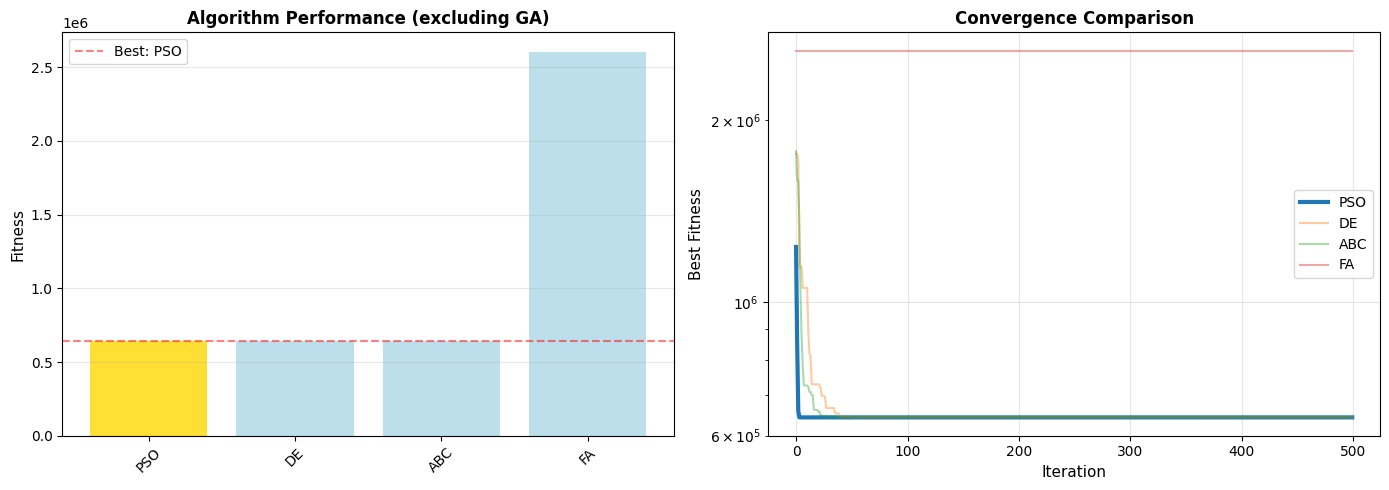


🎯 FINAL: GA (project requirement) + PSO (best performance)


  PHASE 2: FINAL TESTS
  Algorithms: GA, PSO
  Surrogate Model: Kriging (Gaussian Process)


--- 1000 ITERATIONS ---
1. GA... ✓ 645349.7 (28.8s)
2. GA+Surr... ✓ 1356114.7 (1104.5s)
3. PSO... ✓ 643307.9 (22.9s)
4. PSO+Surr... ✓ 643307.9 (35.7s)

--- 5000 ITERATIONS ---
1. GA... ✓ 644043.7 (123.0s)
2. GA+Surr... ✓ 987560.2 (3877.7s)
3. PSO... ✓ 698695.1 (112.0s)
4. PSO+Surr... ✓ 643307.9 (131.2s)


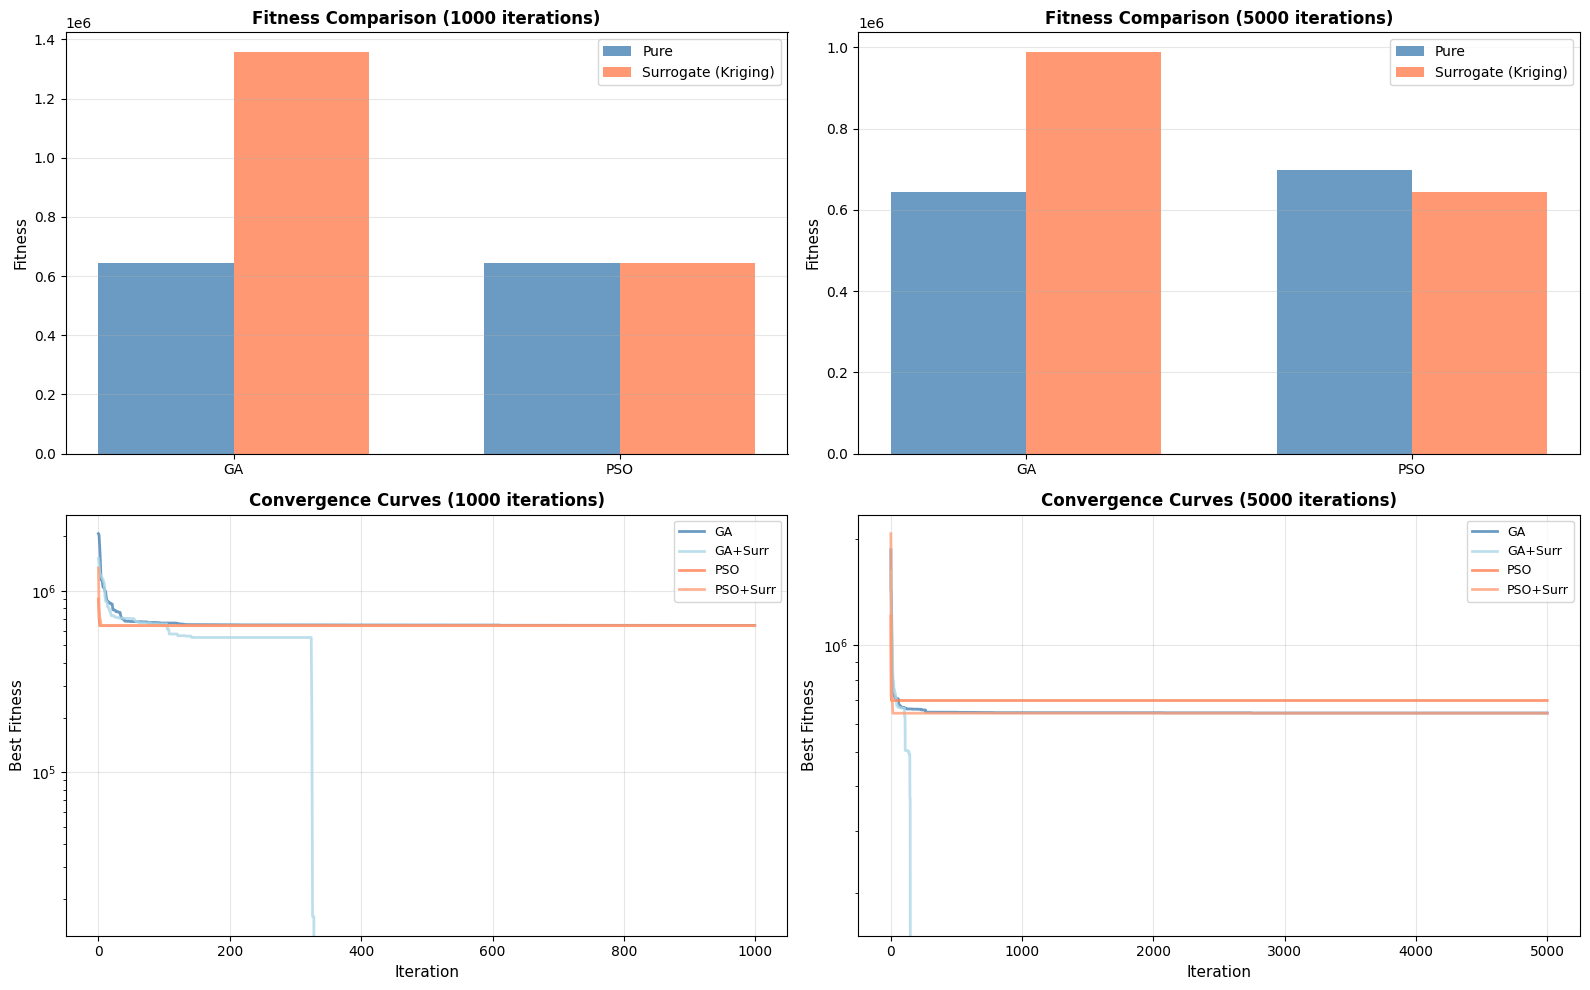


  FINAL RESULTS - Surrogate Model: Kriging (Gaussian Process)
Algo   | Iter   |    Pure Fit |    Surr Fit |       Δ% |  Pure(s) |  Surr(s) |  Speedup
----------------------------------------------------------------------------------------------------
GA     | 1000   |    645349.7 |   1356114.7 |  -110.1% |    28.82 |  1104.52 |    0.03x
GA     | 5000   |    644043.7 |    987560.2 |   -53.3% |   123.01 |  3877.74 |    0.03x
PSO    | 1000   |    643307.9 |    643307.9 |    +0.0% |    22.91 |    35.71 |    0.64x
PSO    | 5000   |    698695.1 |    643307.9 |    +7.9% |   111.98 |   131.23 |    0.85x

  SUMMARY:
  • Selected algorithms: GA, PSO
  • Best pure algorithm (1000 iter): PSO (Fitness: 643307.9)
  • Best pure algorithm (5000 iter): GA (Fitness: 644043.7)
  • Best surrogate algorithm (5000 iter): PSO (Fitness: 643307.9)
  • Surrogate model: Kriging (Gaussian Process)


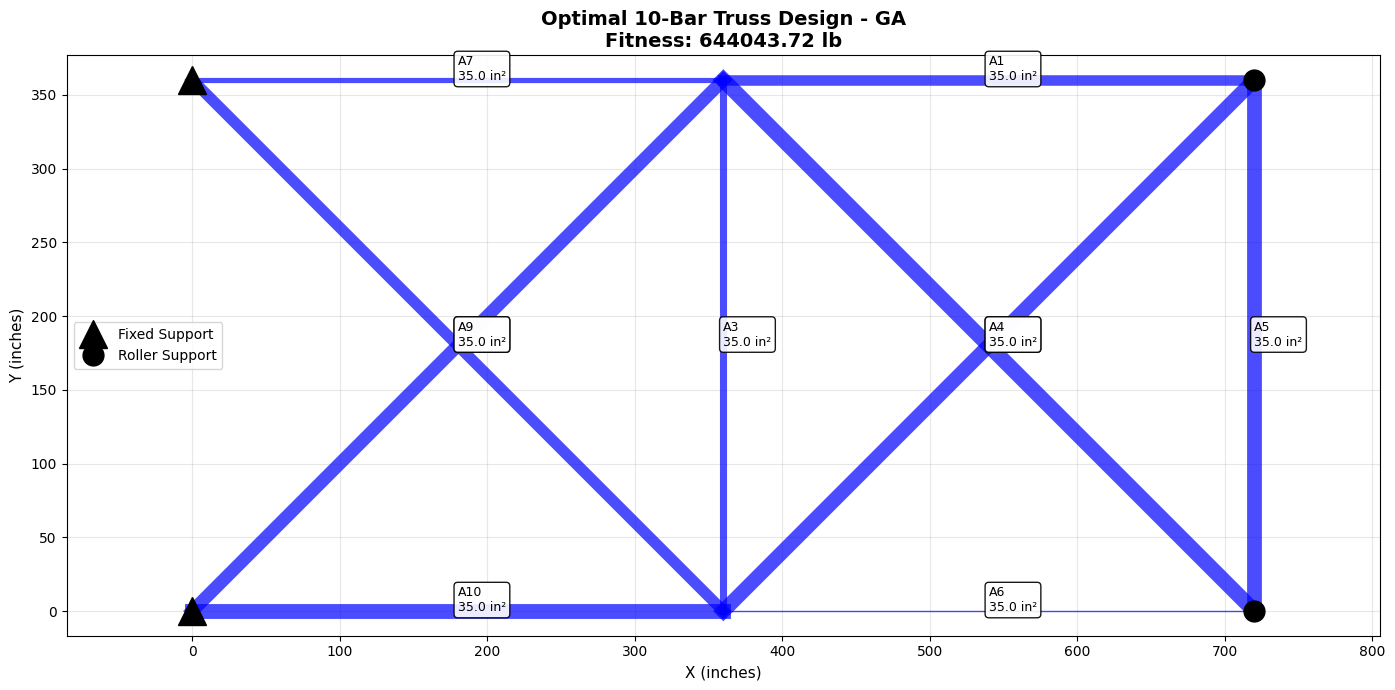


✅ ALL ANALYSES COMPLETED!
📁 Saved files:
   - outputs/algorithm_selection.png
   - outputs/final_comparison.png
   - outputs/best_truss_design.png


In [18]:
if __name__ == "__main__":
    # NOTE: Import required classes from the main file
    # from complete_project_corrected import (
    #     TenBarTruss, SurrogateManager, GeneticAlgorithm, ParticleSwarmOptimization
    # )
    
    # Create problem instance
    truss = TenBarTruss()
    
    print("="*70)
    print("  10-BAR TRUSS OPTIMIZATION")
    print("  PHASE 1: Algorithm Selection (500 iterations)")
    print("  PHASE 2: Final Tests - GA vs Best (1000 & 5000 iterations)")
    print("="*70)
    
    # PHASE 1: Find best 2nd algorithm
    best_second_algo, selection_results = find_best_second_algorithm(
        problem=truss,
        iterations=500,
        pop_size=30
    )
    
    print(f"\n🎯 FINAL: GA (project requirement) + "
          f"{best_second_algo} (best performance)\n")
    
    # PHASE 2: Final tests
    final_results = final_tests(
        problem=truss,
        second_algorithm=best_second_algo,
        iterations=[1000, 5000]
    )
    
    # Visualize and analyze
    visualize_and_analyze(final_results, best_second_algo)
    
    print("\n✅ ALL ANALYSES COMPLETED!")
    print("📁 Saved files:")
    print("   - outputs/algorithm_selection.png")
    print("   - outputs/final_comparison.png")
    print("   - outputs/best_truss_design.png")